<a href="https://colab.research.google.com/github/gilad-altshuler/Deep_Learning/blob/main/ECG_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!cp -r /content/drive/MyDrive/Deep_Learning/* . #line 1

# import sys
# sys.path.append('/content/drive/MyDrive/Deep_Learning/datasets') # line 2

Mounted at /content/drive


##data preparation

In [3]:
def create_pd(train_path,test_path):
    train=pd.read_csv(train_path)
    test=pd.read_csv(test_path)
    train.columns=[x for x in range(188)]
    test.columns=[x for x in range(188)]
    return train,test

In [4]:
mit_train_path="./datasets/mitbih_train.csv"
mit_test_path="./datasets/mitbih_test.csv"

In [5]:
mit_train, mit_test= create_pd(mit_train_path,mit_test_path)
mit_train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
print("train relative percentage: {:.3f}%".format(mit_train.shape[0]*100/(mit_train.shape[0]+mit_test.shape[0])))
print("test relative percentage: {:.3f}%".format(mit_test.shape[0]*100/(mit_train.shape[0]+mit_test.shape[0])))

train relative percentage: 79.998%
test relative percentage: 20.002%


##model

In [15]:
class HeartBeatNet(nn.Module):
  def __init__(self):
    super(HeartBeatNet, self).__init__()
    self.conv_layer = nn.Sequential(
        # Conv Layer block 1
        nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding='valid'),
        nn.BatchNorm1d(32),
        nn.ReLU(inplace=True),

        # Conv Layer block 2
        nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding='valid'),
        nn.BatchNorm1d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool1d(kernel_size=3),

        # Conv Layer block 3
        nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding='valid'),
        nn.BatchNorm1d(128),
        nn.ReLU(inplace=True),

        # Conv Layer block 4
        nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding='valid'),
        nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.AvgPool1d(kernel_size=3)
    )

    self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.3),

        nn.Linear(4608, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.3),

        nn.Linear(1024, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.3),

        nn.Linear(256, 32),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.3),

        nn.Linear(32, 5)
    )
  def forward(self,x):
    """
    x: 1-dim vector of size (Batch ,1, HEARTBEAT_SIZE)
    return: forward pass of x to the convolution and fully connected layers
    """

    x = self.conv_layer(x)
    x = x.view(x.size(0), -1)
    x = self.fc_layer(x)

    return x

##Train

device

In [16]:
if torch.cuda.is_available():
    print("current cuda device: ", torch.cuda.current_device())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("running calculations on device: ", device)

current cuda device:  0
running calculations on device:  cuda:0


model

In [17]:
model = HeartBeatNet().to(device)

N.o. weight parameters

In [18]:
num_trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print("num trainable weights: ", num_trainable_params)
size_model = 0
for param in model.parameters():
  if param.data.is_floating_point():
    size_model += param.numel() * torch.finfo(param.data.dtype).bits
  else:
    size_model += param.numel() * torch.iinfo(param.data.dtype).bits
print(f"model size: {size_model} / bit | {size_model / 8e6:.2f} / MB")

num trainable weights:  5125125
model size: 164004000 / bit | 20.50 / MB


hyperparameters

In [19]:
nb_class = 5

batch_size = 64
learning_rate = 1e-4
epochs = 20

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

define the dataset

In [20]:
from torch.utils.data import TensorDataset

X_train = torch.tensor(mit_train.loc[:,:186].values,dtype = torch.float32).unsqueeze(1)
y_train = torch.tensor(mit_train.loc[:,187:].values,dtype=torch.int64).squeeze()

X_test = torch.tensor(mit_test.loc[:,:186].values,dtype = torch.float32).unsqueeze(1)
y_test = torch.tensor(mit_test.loc[:,187:].values,dtype=torch.int64).squeeze()

trainloader = torch.utils.data.DataLoader(TensorDataset(X_train,y_train),
 batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(TensorDataset(X_test,y_test),
 batch_size=batch_size, shuffle=False, num_workers=2)

define the accuracy

In [21]:
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode
    total_correct = 0
    total_ecg = 0
    with torch.no_grad():
        for data in dataloader:
            ecgs, labels = data
            ecgs = ecgs.to(device)
            labels = labels.to(device)

            outputs = model(ecgs)
            _, predicted = torch.max(outputs.data, 1)
            total_ecg += labels.size(0)
            total_correct += (predicted == labels).sum().item()
    model_accuracy = total_correct / total_ecg * 100
    return model_accuracy

train loop

In [22]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
 
 # training loop
for epoch in range(1, epochs + 1):
    model.train() # put in training mode
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        ecgs, labels = data
        # send them to device
        ecgs = ecgs.to(device)
        labels = labels.to(device)
        # forward + backward + optimize
        outputs = model(ecgs) # forward pass
        loss = criterion(outputs, labels) # calculate the loss

        optimizer.zero_grad() # zero the parameter gradients
        loss.backward() # backpropagation
        optimizer.step() # update parameters
        # print statistics
        running_loss += loss.data.item()

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    #calculate the test loss for epoch
    # # test_loss = calculate_test_loss(model, (X_test,y_test), criterion, device)

    # Calculate training/test set accuracy of the existing model
    train_accuracy = calculate_accuracy(model, trainloader, device)
    test_accuracy = calculate_accuracy(model, testloader, device)
    log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}%  ".format(epoch, running_loss, train_accuracy,test_accuracy)
    print(log)

    # save model
    train_losses.append(running_loss)
    # test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

Epoch: 1 | Loss: 0.2167 | Training accuracy: 97.275% | Test accuracy: 96.994%  
Epoch: 2 | Loss: 0.1046 | Training accuracy: 98.127% | Test accuracy: 97.762%  
Epoch: 3 | Loss: 0.0829 | Training accuracy: 98.090% | Test accuracy: 97.757%  
Epoch: 4 | Loss: 0.0715 | Training accuracy: 98.561% | Test accuracy: 98.086%  
Epoch: 5 | Loss: 0.0639 | Training accuracy: 98.427% | Test accuracy: 97.853%  
Epoch: 6 | Loss: 0.0570 | Training accuracy: 98.912% | Test accuracy: 98.355%  
Epoch: 7 | Loss: 0.0529 | Training accuracy: 98.801% | Test accuracy: 98.310%  
Epoch: 8 | Loss: 0.0481 | Training accuracy: 98.981% | Test accuracy: 98.333%  
Epoch: 9 | Loss: 0.0448 | Training accuracy: 99.006% | Test accuracy: 98.324%  
Epoch: 10 | Loss: 0.0420 | Training accuracy: 99.065% | Test accuracy: 98.429%  
Epoch: 11 | Loss: 0.0373 | Training accuracy: 99.270% | Test accuracy: 98.575%  
Epoch: 12 | Loss: 0.0349 | Training accuracy: 99.235% | Test accuracy: 98.570%  
Epoch: 13 | Loss: 0.0340 | Training a

In [23]:
print("final accuracies:")
print("\ttest accuracy: {:.5f}%\n\ttrain accuracy: {:.5f}%".format(test_accuracies[-1],train_accuracies[-1]))

final accuracies:
	test accuracy: 98.66155%
	train accuracy: 99.57397%


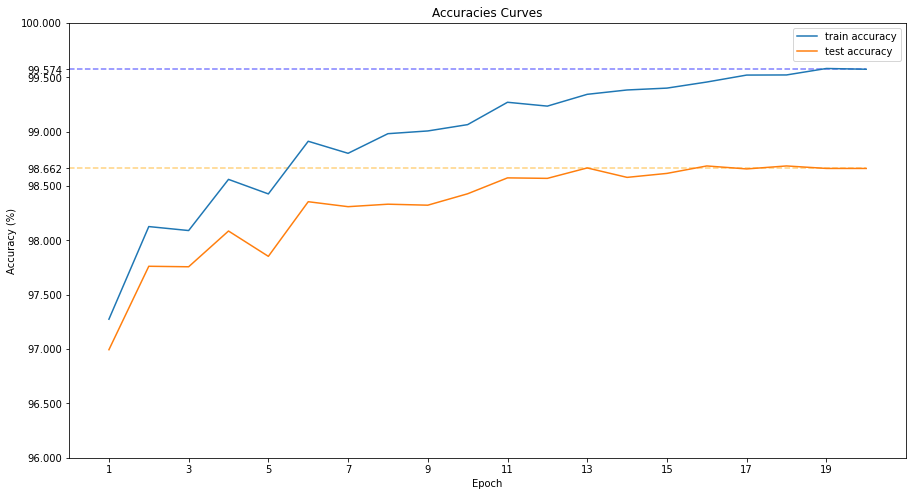

In [62]:
figure = plt.figure(figsize=(15,8))
ax = figure.add_subplot(1,1,1)
ax.plot(range(1,epochs+1),train_accuracies,label = "train accuracy")
ax.plot(range(1,epochs+1),test_accuracies,label = "test accuracy")
ax.hlines(test_accuracies[-1],xmin=0,xmax=20,colors='orange',linestyles='dashed',alpha=0.5)
ax.hlines(train_accuracies[-1],xmin=0,xmax=20,colors='blue',linestyles='dashed',alpha=0.5)
ax.legend()
ax.set_title("Accuracies Curves")
ax.set_xticks(range(1,epochs+1,2))
ax.set_xlim(left=0)
ax.set_yticks(np.concatenate([np.linspace(96,100,9),[train_accuracies[-1],test_accuracies[-1]]]))
ax.set_xlabel("Epoch")
_=ax.set_ylabel("Accuracy (%)")